In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tensorboardX import SummaryWriter
import yaml
import math

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from models.yolo import Model
from utils.datasets import create_dataloader
from utils.losses import YOLOLoss
import torch.optim.lr_scheduler as lr_scheduler

from utils.general import (
    check_img_size, labels_to_class_weights)

[2022-07-14 07:35:40.105 ip-172-31-4-88:23157 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-14 07:35:40.155 ip-172-31-4-88:23157 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


In [3]:
class Args():
    pass

opt = Args()
opt.cfg = "models/yolov4-p5.yaml"
opt.data = "data/coco.yaml"
opt.sync_bn = True
opt.batch_size = 2
opt.adam = True
opt.resume = False
opt.weights = ''
opt.epochs = 300
opt.img_size = 896
opt.cache_images = False
opt.name = "test"
opt.hyp = 'data/hyp.scratch.yaml'
opt.single_cls = False
with open(opt.hyp) as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)
with open(opt.data) as f:
    data_dict = yaml.load(f, Loader=yaml.FullLoader) 
    
train_path = data_dict['train']
test_path = data_dict['val']
nc, names = (1, ['item']) if opt.single_cls else (int(data_dict['nc']), data_dict['names'])  # number classes, names

device = 'cuda'

In [4]:
model = Model(opt.cfg, ch=3, nc=nc).to(device)


                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     19904  models.common.BottleneckCSP             [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    161152  models.common.BottleneckCSP             [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1   2614016  models.common.BottleneckCSP             [256, 256, 15]                
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1  10438144  

In [5]:
pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
for k, v in model.named_parameters():
    v.requires_grad = True
    if '.bias' in k:
        pg2.append(v)  # biases
    elif '.weight' in k and '.bn' not in k:
        pg1.append(v)  # apply weight decay
    else:
        pg0.append(v)  # all else
optimizer = torch.optim.Adam(pg0, lr=hyp['lr0'], betas=(hyp['momentum'], 0.999))
optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
print('Optimizer groups: %g .bias, %g conv.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
del pg0, pg1, pg2
lf = lambda x: (((1 + math.cos(x * math.pi / opt.epochs)) / 2) ** 1.0) * 0.8 + 0.2
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)

Optimizer groups: 158 .bias, 163 conv.weight, 155 other


In [6]:
gs = int(max(model.stride))
imgsz = opt.img_size

In [7]:
dataloader, dataset = create_dataloader(train_path, 
                                        imgsz, 
                                        opt.batch_size, 
                                        gs, 
                                        opt, 
                                        hyp=hyp, augment=True,
                                            cache=opt.cache_images, rect=False, local_rank=-1,
                                            world_size=1)

Scanning labels /workspace/desktop/data/coco/yolo/coco/labels/train2017.cache (117266 found, 0 missing, 1021 empty, 0 duplicate, for 118287 images): 100%|██████████| 118287/118287 [00:08<00:00, 14765.82it/s]


In [8]:
hyp['cls'] *= nc / 80.
model.nc = nc  # attach number of classes to model
model.hyp = hyp  # attach hyperparameters to model
model.gr = 1.0  # giou loss ratio (obj_loss = 1.0 or giou)
model.class_weights = labels_to_class_weights(dataset.labels, nc).to(device)  # attach class weights
model.names = names

In [9]:
dataloader = iter(dataloader)

In [10]:
imgs, targets, files, _ = next(dataloader)
imgs = imgs.to(device, non_blocking=True).float() / 255.0 
pred = model(imgs)

In [11]:
first_layer = '.'.join(list(model.named_parameters())[0][0].split('.')[:-1]) + '.*'
last_layer = '.'.join(list(model.named_parameters())[-1][0].split('.')[:-1]) + '.*'

In [12]:
import os
from datetime import datetime

import boto3
from sagemaker import analytics, image_uris
from sagemaker.pytorch import PyTorch
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    TensorBoardOutputConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile,
    DetailedProfilingConfig,
    DataloaderProfilingConfig,
    rule_configs,
)
from smdebug.core.collection import CollectionKeys


In [13]:
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

time_str = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")

region = boto3.session.Session().region_name
boto_sess = boto3.Session()
sm = boto_sess.client('sagemaker')

s3_bucket = "s3://jbsnyder-sagemaker-us-east/"

base_job_name = "jbsnyder-yolo"
date_str = datetime.now().strftime("%d-%m-%Y")
time_str = datetime.now().strftime("%d-%m-%Y-%H-%M-%S")
job_name = f"{base_job_name}-{time_str}"

output_path = os.path.join(s3_bucket, "sagemaker-output", date_str, job_name)
code_location = os.path.join(s3_bucket, "sagemaker-code", date_str, job_name)

In [14]:
tensorboard_output_config = TensorBoardOutputConfig(s3_output_path=os.path.join(output_path, 'tensorboard'))

In [15]:
collection_configs=[
    CollectionConfig(
        name=CollectionKeys.LOSSES,
        parameters={
            "train.save_interval": "10",
            "eval.save_interval": "1",
        }
    ),
    CollectionConfig(
        name="inputs",
        parameters={
            "train.save_interval": "50",
            "eval.save_interval": "10",
            "include_regex": first_layer,
        }
    ),
    CollectionConfig(
        name="outputs",
        parameters={
            "train.save_interval": "50",
            "eval.save_interval": "10",
            "include_regex": last_layer,
        }
    ),
    CollectionConfig(
        name=CollectionKeys.WEIGHTS,
        parameters={
            "train.save_interval": "100",
            "eval.save_interval": "10",
            "reductions": "mean",
        }
    ),
    CollectionConfig(
        name=CollectionKeys.GRADIENTS,
        parameters={
            "train.save_interval": "100",
            "eval.save_interval": "10",
            "reductions": "mean",
        }
    ),
    CollectionConfig(
        name="metrics",
        parameters={
            "eval.save_interval": "1",
            "include_regex": "metrics*",
        }
    ),
    CollectionConfig(
        name="validation",
        parameters={
            "eval.save_interval": "1",
            "include_regex": "val*",
        }
    ),
]

debugger_hook_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [16]:
profiler_config=ProfilerConfig(
    system_monitor_interval_millis=500,
)


In [19]:
hyperparameters = {"batch-size": 64,
                   "epochs": 10,
                   "data": "coco_sagemaker.yaml",
                   "cfg": "yolov4-p5.yaml",
                   "sync-bn": "True",
                   "adam": "True",
                   "multi-scale": "True",
                   "name": "yolov4-p5",
                   "logdir": "/opt/ml/model/"
                   }

In [20]:
distribution=None
entry_point="launch_ddp.py"

In [21]:
instance_type = 'ml.p4d.24xlarge'
# instance_type = 'local_gpu'
instance_count = 1

repo = "jbsnyder"
tag = "pytorch-yolo"
account = os.popen(f"aws sts get-caller-identity --region {region} --endpoint-url https://sts.{region}.amazonaws.com --query Account --output text").read().strip()
image_uri = f"{account}.dkr.ecr.{region}.amazonaws.com/{repo}:{tag}"

In [22]:
estimator = PyTorch(
    source_dir=".",
    entry_point=entry_point,
    base_job_name=job_name,
    role=get_execution_role(),
    instance_count=instance_count,
    instance_type=instance_type,
    distribution=distribution,
    volume_size=400,
    max_run=3600*8,
    hyperparameters=hyperparameters,
    image_uri=image_uri,
    output_path=os.path.join(output_path, 'training-output'),
    checkpoint_s3_uri=os.path.join(output_path, 'training-checkpoints'),
    model_dir=os.path.join(output_path, 'training-model'),
    code_location=code_location,
    ## Debugger parameters
    #metric_definitions=metric_definitions,
    enable_sagemaker_metrics=True,
    #rules=rules,
    debugger_hook_config=debugger_hook_config,
    disable_profiler=False,
    tensorboard_output_config=tensorboard_output_config,
    profiler_config=profiler_config,
    input_mode='File',
)

In [23]:
channels={"all_data": "s3://jbsnyder-sagemaker-us-east/data/yolo/"}

In [24]:
# Run training
estimator.fit(
    inputs=channels,
    wait=False,
    job_name=job_name,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: jbsnyder-yolo-14-07-2022-07-35-57


In [ ]:
estimator.logs()

2022-07-14 07:36:25 Starting - Starting the training job...ProfilerReport-1657784183: InProgress
...
2022-07-14 07:37:08 Starting - Preparing the instances for training.............................................
2022-07-14 07:44:50 Downloading - Downloading input data.......................

In [48]:
estimator.output_path

's3://jbsnyder-sagemaker-us-east/sagemaker-output/14-07-2022/jbsnyder-yolo-14-07-2022-05-58-51/training-output'

In [49]:
from s3fs import S3FileSystem
from smdebug.core.tfevent.event_file_reader import EventFileReader
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [50]:
s3 = S3FileSystem()

In [54]:
s3.ls(os.path.join(output_path, 'tensorboard'))

[]

In [55]:
event_output = s3.ls(os.path.join(estimator.output_path, job_name, 'debug-output', 'events'))

event_files = [s3.ls(i)[0] for i in event_output]


In [56]:
reader = EventFileReader('s3://'+event_files[10])

In [57]:
tensor_events = {i[0]: i[2] for i in reader.read_tensors()}

In [58]:
[i for i in tensor_events.keys() if 'input' in i]

['module.model.0.conv_input_0', 'module.model.31.m.2_input_0']

In [59]:
img = np.transpose(tensor_events['module.model.0.conv_input_0'][0], (1, 2, 0))

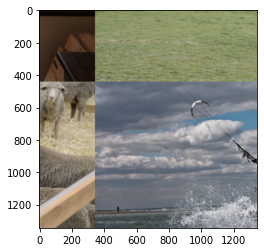

In [60]:
plt.imshow(img)